In [1]:
import sys
from pathlib import Path
sys.path.append('..')
from src.data import make_dataset
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from mpl_toolkits.basemap import Basemap
from sklearn.impute import SimpleImputer
import numpy as np

In [2]:
root = Path.cwd().parents[0]
train_path = root.joinpath('data').joinpath('processed').joinpath('train_set_strat.csv')
train = make_dataset.load_housing_data(train_path)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 12 columns):
Unnamed: 0            16512 non-null int64
Unnamed: 0.1          16512 non-null int64
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), int64(2), object(1)
memory usage: 1.5+ MB


## Mapping the Data

We deviate from the book in some respects in this section. In particular, we preview the use of Basemap to place the points of interest on an outline map of California instead of leaving the points floating.

/home/djliden91/.virtualenvs/homl_housing/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


/home/djliden91/.virtualenvs/homl_housing/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/djliden91/.virtualenvs/homl_housing/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


No handles with labels found to put in legend.


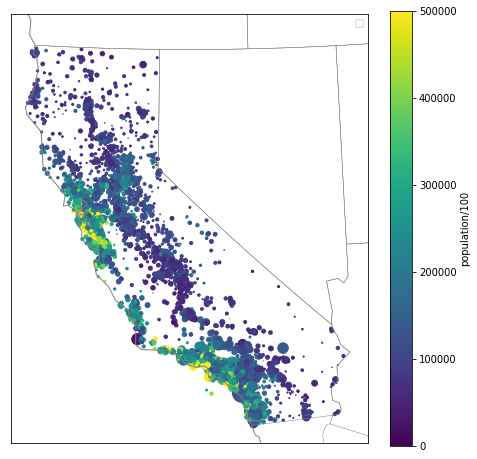

In [3]:
lon = train["longitude"].tolist()
lat = train["latitude"].tolist()
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='l', lat_0=37.5, lon_0=-119, width=1e6, height=1.2e6)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

m.scatter(x = lon, y = lat, c=train["median_house_value"], s=train["population"]/100,
         latlon=True)

plt.colorbar(label='population/100')
plt.clim(0,500000)

#train.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.4,
#           s=train["population"]/100, label="population", figsize=(10,7),
#           c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
#          )
plt.legend()

Clearly, housing prices are related to location: close to the coast, we see higher prices; inland, we see lower prices.

## Looking for Correlations

We can compute Pearson's r between each attribute pair to see how strongly correlated each feature is with mean housing value. Note that this only measures linear correlation and may miss nonlinear relationships. Here, it serves as a rough tool to start to give a sense of what features may be of particular interest, but it should not be taken as offering absolute answers.

In [4]:
corr_matrix = train.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
Unnamed: 0.1          0.067723
Unnamed: 0            0.067723
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The median income is most strongly linearly correlated with house value. We can also look at how correlated the features are with each other.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f331be87668>,
      dtype=object)

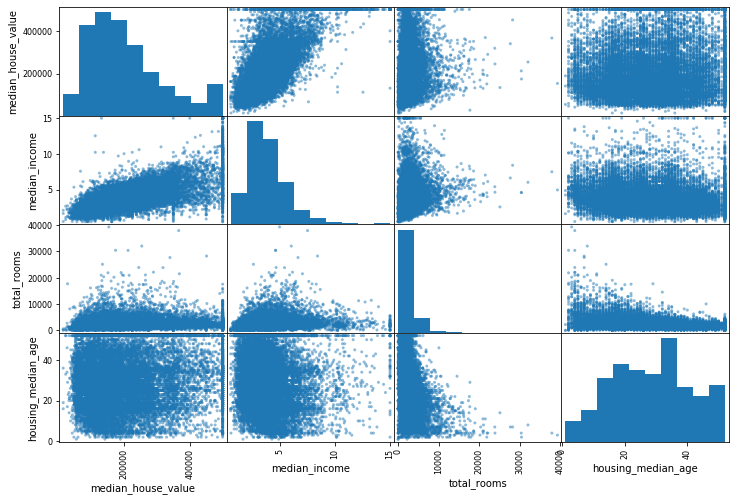

In [5]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(train[attributes], figsize=(12,8))

Median income again looks the most influential, so we'll take a closer look.

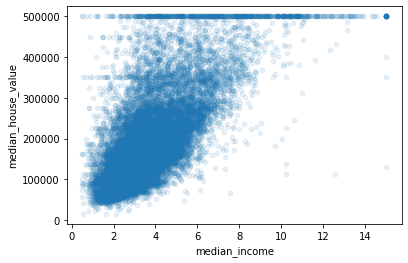

In [6]:
train.plot(kind="scatter", x = "median_income", y = "median_house_value", alpha = 0.1)

1. The correlation looks quite strong
2. There is a max house value cutoff at \\$500,001
3. There appear to be some smaller cutoffs around \\$350,000 and \\$450,000

Let's remove the data points at these cutoffs as they are likely not accurate and may bias the results.

In [7]:
#train = train.drop(train.median_house_value])
indices = train[train.median_house_value.isin((350000,450000,500001))].index
train = train.drop(indices)
train.plot(kind="scatter", x = "median_income", y = "median_house_value", alpha = 0.1)

Now we don't see any worrying horizontal lines.

## Experimenting with Attribute Combinations

Some attributes aren't very useful in their raw forms. For example, number of rooms per district isn't very useful without knowing number of households: number of rooms per household is more useful. Similarly, number of bedrooms is most useful in the context of the number of total rooms.

In [12]:
train["rooms_per_household"] = train["total_rooms"]/train["households"]
train["bedrooms_per_room"] = train["total_bedrooms"]/train["total_rooms"]
train["population_per_household"] = train["population"]/train["households"]

In [8]:
corr_matrix = train.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.652629
total_rooms           0.150469
households            0.099066
total_bedrooms        0.077579
housing_median_age    0.071242
Unnamed: 0.1          0.062958
Unnamed: 0            0.062958
population            0.014728
longitude            -0.041462
latitude             -0.152141
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms

Now we go through a more nuanced data cleaning process starting from the stratified training data.

In [9]:
train = make_dataset.load_housing_data(train_path)
train_labels = train["median_house_value"].copy()
train_unlabeled = train.drop("median_house_value",axis=1).drop("Unnamed: 0", axis = 1).drop("Unnamed: 0.1", axis = 1)

In [10]:
train_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.1+ MB


### Missing Features

It is pretty easy to drop missing values with `DataFrame` using functions such as `dropna()` and `drop()` and `fillna()`. We will instead use `sklearn`'s `SimpleImputer`.

In [11]:
imputer = SimpleImputer(strategy = "median")
# Need to create copy with only numerical fields to work on

train_num = train_unlabeled.drop("ocean_proximity", axis = 1)
imputer.fit(train_num)

imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [12]:
X = imputer.transform(train_num)

In [13]:
train_unlabeled_imputed = pd.DataFrame(X, columns=train_num.columns)

In [14]:
train_unlabeled_imputed.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -121.89     37.29                38.0       1568.0           351.0   
1    -121.93     37.05                14.0        679.0           108.0   
2    -117.20     32.77                31.0       1952.0           471.0   
3    -119.61     36.31                25.0       1847.0           371.0   
4    -118.59     34.23                17.0       6592.0          1525.0   

   population  households  median_income  
0       710.0       339.0         2.7042  
1       306.0       113.0         6.4214  
2       936.0       462.0         2.8621  
3      1460.0       353.0         1.8839  
4      4459.0      1463.0         3.0347

### Dealing with text attributes

Here we convert the text field "promimity to ocean" to an ordinal variable.

In [15]:
housing_cat = train_unlabeled[["ocean_proximity"]]
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

Next we use one-hot encoding because we do not actually want the ordinal representation.

In [16]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

`scikit-learn` is fairly straightforwardly extensible as shown below.

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(train_unlabeled.values)

### Pipelines

`scikit-learn` offers the ability to combine data transformation operations into pipelines, helping with organization and transformation sequencing.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

train_num_tr = num_pipeline.fit_transform(train_num)

`ColumnTransformer` lets us apply changes to both categorical and numerical columns.

In [19]:
from sklearn.compose import ColumnTransformer

num_attributes = list(train_num)
cat_attributes = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", OneHotEncoder(), cat_attributes),
])

housing_prepared = full_pipeline.fit_transform(train)

In [24]:
housing_prepared[1:5]

array([[-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0.92673619,  1.85619316,  2.41221109,
         2.72415407,  2.57097492, -0.44143679, -0.35783383, -0.00419445,
         0.2699277 ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])